In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pickle
import os
import logging
import time
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset_unet import prepare_trainset
from utils import save_checkpoint, load_checkpoint, set_logger
from gpu_utils import set_n_get_device

from model.model_unet_attention import R2AttU_Net

%matplotlib inline

In [2]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'R2AttU_Net'#
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("1", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = None#[0, 1]#use 2 gpus

SEED = 1234#5678#4567#3456#2345#1234
debug = True# if True, load 100 samples
IMG_SIZE = 512
BATCH_SIZE = 2
NUM_WORKERS = 24
torch.cuda.manual_seed_all(SEED)

====MODEL ACHITECTURE: R2AttU_Net====


## the dataset

In [3]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug)

Count of trainset (for training):  900
Count of validset (for training):  100


In [4]:
for i, (images, masks) in enumerate(train_dl):
    images = images.to(device=device, dtype=torch.float)
    masks = masks.to(device=device, dtype=torch.float)
    #labels = (torch.sum(masks.reshape(masks.size()[0], -1), dim=1, keepdim=True)==0).to(device=device, dtype=torch.float) #1 for non-zero-mask
    if i==0:
        break

In [5]:
images.size(), masks.size()#, labels.size()

(torch.Size([2, 1, 512, 512]), torch.Size([2, 1, 512, 512]))

## the model

In [6]:
net = R2AttU_Net(debug=True).cuda(device=device)

#checkpoint_path = 'checkpoint/UNetResNet34_512_v1_seed3456/best.pth.tar'
#net, _ = load_checkpoint(checkpoint_path, net)

if multi_gpu is not None:
    net = nn.DataParallel(net, device_ids=multi_gpu)

In [7]:
logit = net(images)

input:  torch.Size([2, 3, 512, 512])
RRCNN1:  torch.Size([2, 64, 512, 512])
RRCNN2:  torch.Size([2, 64, 256, 256])
RRCNN3:  torch.Size([2, 128, 128, 128])
RRCNN4:  torch.Size([2, 256, 64, 64])
RRCNN5:  torch.Size([2, 512, 32, 32])
====decoder====
Up_RRCNN5:  torch.Size([2, 256, 64, 64])
Up_RRCNN4:  torch.Size([2, 128, 128, 128])
Up_RRCNN3:  torch.Size([2, 64, 256, 256])
Up_RRCNN2:  torch.Size([2, 64, 512, 512])
logit:  torch.Size([2, 1, 512, 512])


In [8]:
logit.size(), masks.size()

(torch.Size([4, 1, 512, 512]), torch.Size([4, 1, 512, 512]))

In [9]:
# Loss_FUNC = nn.BCEWithLogitsLoss()
# bce_loss = Loss_FUNC(logit, masks)
# bce_loss

In [9]:
if multi_gpu is not None:
    _loss = net.module.criterion(logit, masks)
else:
    _loss = net.criterion(logit, masks)

_loss

tensor(0.8047, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [10]:
if multi_gpu is not None:
    _metric = net.module.metric(logit, masks)
else:
    _metric = net.metric(logit, masks)
_metric

tensor(3.8147e-14, device='cuda:0')

## predict the validset, and analyse

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import pickle
import os
import logging
import time
import gc
from IPython.core.debugger import set_trace

import torch
import torch.nn as nn
import torch.nn.functional as F

from utils import save_checkpoint, load_checkpoint, set_logger
from gpu_utils import set_n_get_device

from model.deeplab_model_kaggler.deeplab import DeepLab, predict_proba
from dataset_unet import prepare_trainset

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(x):
    return np.log(x / (1-x))

%matplotlib inline

In [2]:
######### Config the training process #########
#device = set_n_get_device("0, 1, 2, 3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
MODEL = 'resnet'#
#AUX_LOGITS = True#False, only for 'INCEPTION_V3'
print('====MODEL ACHITECTURE: %s===='%MODEL)

device = set_n_get_device("3", data_device_id="cuda:0")#0, 1, 2, 3, IMPORTANT: data_device_id is set to free gpu for storing the model, e.g."cuda:1"
multi_gpu = None#[0, 1]#use 2 gpus

SEED = 3456#5678#4567#3456#2345#1234
debug = False# if True, load 100 samples
IMG_SIZE = 512
BATCH_SIZE = 8
NUM_WORKERS = 24
torch.cuda.manual_seed_all(SEED)

====MODEL ACHITECTURE: resnet====


In [3]:
train_dl, val_dl = prepare_trainset(BATCH_SIZE, NUM_WORKERS, SEED, IMG_SIZE, debug)

Count of trainset (for training):  9607
Count of validset (for training):  1068


In [4]:
# y should be makeup
y_valid = []
for i, (image, masks) in enumerate(val_dl):
    #if i==10:
    #    break
    truth = masks.to(device=device, dtype=torch.float)
    y_valid.append(truth.cpu().numpy())
y_valid = np.concatenate(y_valid, axis=0)
y_valid.shape

(1064, 1, 512, 512)

In [5]:
net = DeepLab(num_classes=2,
              backbone=MODEL,#resnet34, resnet101
              output_stride=16,#default 16, 8
              sync_bn=None,
              freeze_bn=False,
              debug=False
             ).cuda(device=device)

checkpoint_path = 'checkpoint/deeplabv3plus_resnet_512_v1_seed3456/best.pth.tar'
net, _ = load_checkpoint(checkpoint_path, net)

#net = nn.DataParallel(net, device_ids=multi_gpu)

====USE ResNet101====


In [6]:
%%time
# predict_proba
net.set_mode('valid')#.module
preds_valid = predict_proba(net, val_dl, device, multi_gpu=False, mode='valid', tta=True)

use TTA
CPU times: user 17min 15s, sys: 2min 47s, total: 20min 2s
Wall time: 1min 6s


In [7]:
y_valid.shape, preds_valid.shape

((1064, 1, 512, 512), (1064, 512, 512))

In [8]:
## search for best thresholds
def calculate_dice(logit, truth, EMPTY_THRESHOLD=400, MASK_THRESHOLD=0.22):
    IMG_SIZE = logit.shape[-1] #256
    logit = sigmoid(logit)#.reshape(n, -1)
    pred = (logit>MASK_THRESHOLD).astype(np.int)
    pred_clf = (pred.reshape(pred.shape[0], -1).sum(axis=1)<EMPTY_THRESHOLD).astype(np.int)
    pred[pred_clf.reshape(-1,)==1, ] = 0
    return dice_overall(pred, truth)

def dice_overall(pred_mask, truth_mask, eps=1e-8):
    n = pred_mask.shape[0]
    pred_mask = pred_mask.reshape(n, -1)
    truth_mask = truth_mask.reshape(n, -1)
    intersect = (pred_mask * truth_mask).sum(axis=1).astype(np.float)
    union = (pred_mask + truth_mask).sum(axis=1).astype(np.float)
    return ((2.0*intersect + eps) / (union+eps)).mean()

In [11]:
EMPTY_THRESHOLD_candidate = np.arange(1400, 1520, 20)#np.arange(350, 450, 10) for IMG_SIZE=256
MASK_THRESHOLD_candidate = np.arange(0.19, 0.27, 0.01)
M, N = len(EMPTY_THRESHOLD_candidate), len(MASK_THRESHOLD_candidate)
best_threshold = None
best_score = 0

for i in tqdm_notebook(range(M)):
    EMPTY_THRESHOLD = EMPTY_THRESHOLD_candidate[i]
    for j in range(N):
        MASK_THRESHOLD = MASK_THRESHOLD_candidate[j]
        dice_score = calculate_dice(preds_valid, y_valid.squeeze(1), EMPTY_THRESHOLD, MASK_THRESHOLD)
        print('CLF_EMPTY_THRESHOLD: %f, MASK_THRESHOLD: %f, dice_score: %f'%(EMPTY_THRESHOLD, MASK_THRESHOLD, dice_score))
        if dice_score>best_score:
            best_threshold = [EMPTY_THRESHOLD, MASK_THRESHOLD]
            best_score = dice_score

CLF_EMPTY_THRESHOLD: 1400.000000, MASK_THRESHOLD: 0.190000, dice_score: 0.825242
CLF_EMPTY_THRESHOLD: 1400.000000, MASK_THRESHOLD: 0.200000, dice_score: 0.825951
CLF_EMPTY_THRESHOLD: 1400.000000, MASK_THRESHOLD: 0.210000, dice_score: 0.826934
CLF_EMPTY_THRESHOLD: 1400.000000, MASK_THRESHOLD: 0.220000, dice_score: 0.827966
CLF_EMPTY_THRESHOLD: 1400.000000, MASK_THRESHOLD: 0.230000, dice_score: 0.830579
CLF_EMPTY_THRESHOLD: 1400.000000, MASK_THRESHOLD: 0.240000, dice_score: 0.831397
CLF_EMPTY_THRESHOLD: 1400.000000, MASK_THRESHOLD: 0.250000, dice_score: 0.834706
CLF_EMPTY_THRESHOLD: 1400.000000, MASK_THRESHOLD: 0.260000, dice_score: 0.835656
CLF_EMPTY_THRESHOLD: 1400.000000, MASK_THRESHOLD: 0.270000, dice_score: 0.836484
CLF_EMPTY_THRESHOLD: 1420.000000, MASK_THRESHOLD: 0.190000, dice_score: 0.825242
CLF_EMPTY_THRESHOLD: 1420.000000, MASK_THRESHOLD: 0.200000, dice_score: 0.825951
CLF_EMPTY_THRESHOLD: 1420.000000, MASK_THRESHOLD: 0.210000, dice_score: 0.826721
CLF_EMPTY_THRESHOLD: 1420.00

KeyboardInterrupt: 

In [12]:
EMPTY_THRESHOLD, MASK_THRESHOLD = best_threshold
#EMPTY_THRESHOLD, MASK_THRESHOLD, best_score = 1420, 0.24, 0.84
EMPTY_THRESHOLD, MASK_THRESHOLD, best_score

(1420, 0.26000000000000006, 0.8365957104921338)

In [13]:
def predict_mask(logit, EMPTY_THRESHOLD, MASK_THRESHOLD):
    """Transform each prediction into mask.
    input shape: (256, 256)
    """
    #pred mask 0-1 pixel-wise
    #n = logit.shape[0]
    IMG_SIZE = logit.shape[-1] #256
    #EMPTY_THRESHOLD = 100.0*(IMG_SIZE/128.0)**2 #count of predicted mask pixles<threshold, predict as empty mask image
    #MASK_THRESHOLD = 0.22
    #logit = torch.sigmoid(torch.from_numpy(logit)).view(n, -1)
    #pred = (logit>MASK_THRESHOLD).long()
    #pred[pred.sum(dim=1) < EMPTY_THRESHOLD, ] = 0 #bug here, found it, the bug is input shape is (256, 256) not (16,256,256)
    logit = sigmoid(logit)#.reshape(n, -1)
    pred = (logit>MASK_THRESHOLD).astype(np.int)
    if pred.sum() < EMPTY_THRESHOLD:
        return np.zeros(pred.shape).astype(np.int)
    else:
        return pred
    return pred

it seems like ignoring EMPTY_THRESHOLD gives higher recall, although mask is low quality

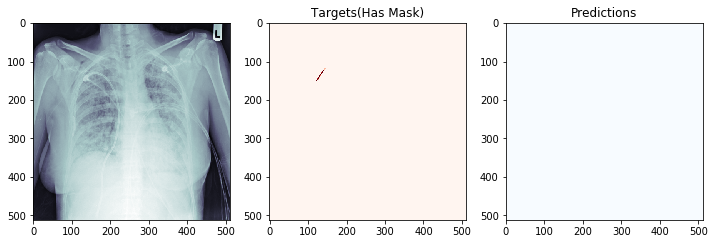

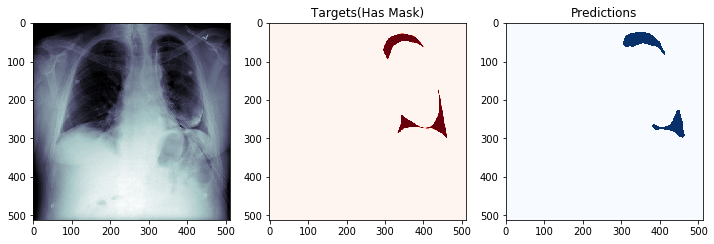

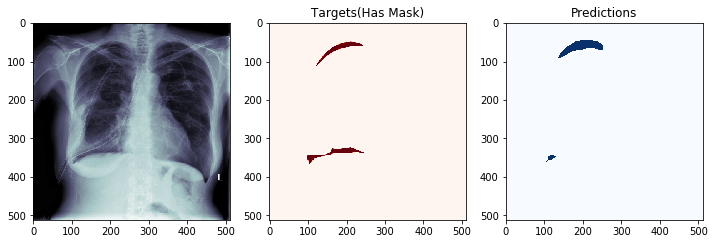

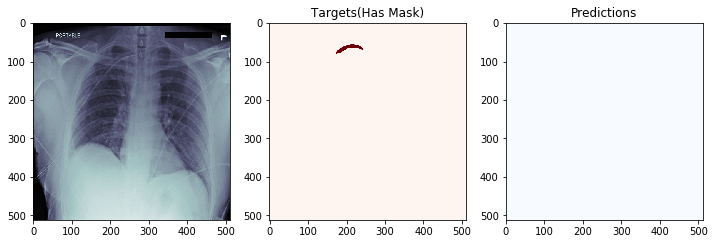

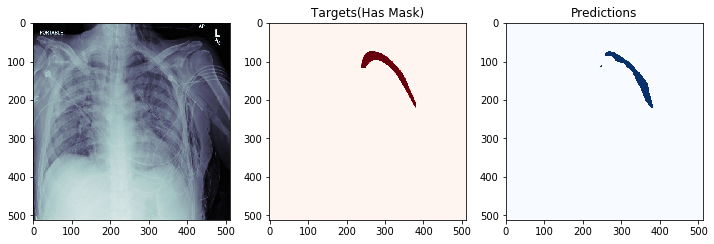

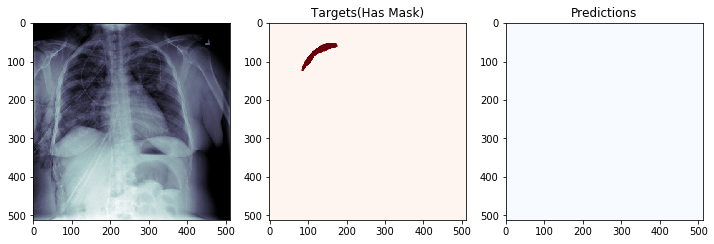

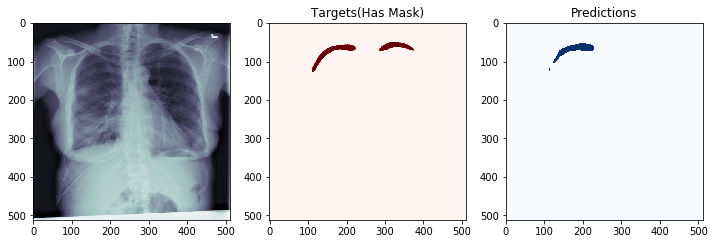

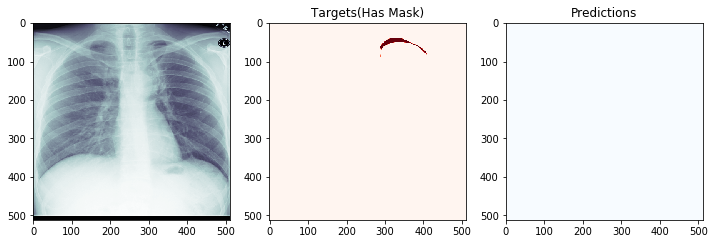

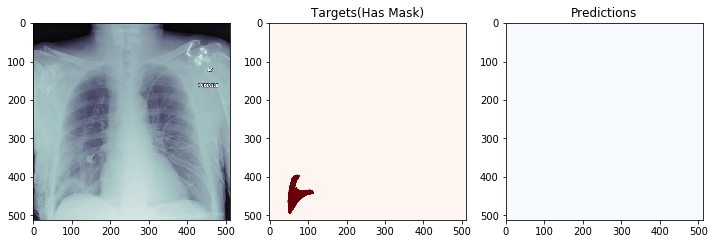

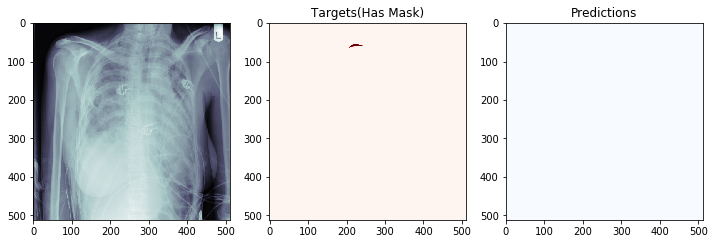

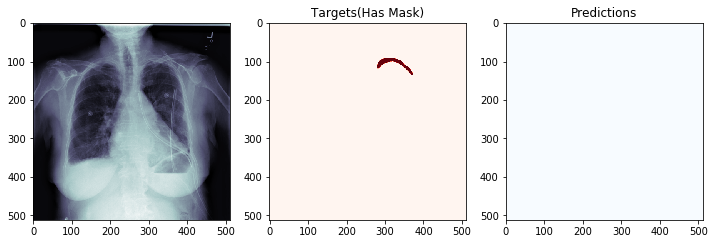

In [15]:
## visualize predicted masks
start = 10
rows = 10

cnt = 0
for idx, (img, mask) in enumerate(val_dl):
    if idx<start:
        continue
    for j in range(BATCH_SIZE):#BATCH_SIZE=8
        not_empty = mask[j][0].sum()>0
        if not_empty:
            cnt+=1
            pred_mask = predict_mask(preds_valid[idx*BATCH_SIZE+j], EMPTY_THRESHOLD, MASK_THRESHOLD)
            #if pred_mask.sum()==0:
            #    continue
            fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
            ax0.imshow(img[j][0].numpy(), plt.cm.bone)
            ax1.imshow(mask[j][0], vmin=0, vmax=1, cmap="Reds")
            ax2.imshow(pred_mask, vmin=0, vmax=1, cmap="Blues")
            if not_empty.item():
                ax1.set_title('Targets(Has Mask)')
            else:
                ax1.set_title('Targets(Empty)')
            ax2.set_title('Predictions')
        if cnt>rows:
            break
    if cnt>rows:
            break

In [ ]:
# ## visualize predicted masks
# rows = 20

# cnt = 0
# for idx, (img, mask) in enumerate(val_dl):
#     for j in range(BATCH_SIZE):#BATCH_SIZE=8
#         is_empty = mask[j][0].sum()==0
#         if is_empty:
#             cnt+=1
#             pred_mask = predict_mask(preds_valid[idx*BATCH_SIZE+j], EMPTY_THRESHOLD, MASK_THRESHOLD)
#             #if pred_mask.sum()==0:
#             #    continue
#             fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
#             ax0.imshow(img[j][0].numpy(), plt.cm.bone)
#             ax1.imshow(mask[j][0], vmin=0, vmax=1, cmap="Reds")
#             ax2.imshow(pred_mask, vmin=0, vmax=1, cmap="Blues")
#             if is_empty.item():
#                 ax1.set_title('Targets(Empty Mask)')
#             else:
#                 ax1.set_title('Targets(Has Mask)')
#             ax2.set_title('Predictions')
#         if cnt>rows:
#             break
#     if cnt>rows:
#             break

In [ ]:
# s = (sigmoid(preds_valid)>MASK_THRESHOLD).reshape(1064, -1).sum(axis=1)
# (s>1420).mean(), (s>0).mean()

## predict the testset

In [16]:
import glob
from dataset_unet import prepare_testset

In [17]:
test_fnames = [f.split('/')[-1][:-4] for f in glob.glob('data/processed/test/*')]
len(test_fnames), test_fnames[0]

(1377, '1.2.276.0.7230010.3.1.4.8323329.6160.1517875196.806852')

In [18]:
test_dl = prepare_testset(BATCH_SIZE, NUM_WORKERS, IMG_SIZE)

In [19]:
%%time
preds_test = predict_proba(net, test_dl, device, multi_gpu=False, mode='test', tta=True)

use TTA
CPU times: user 22min 34s, sys: 3min 33s, total: 26min 7s
Wall time: 1min 32s


In [20]:
preds_test.shape

(1377, 512, 512)

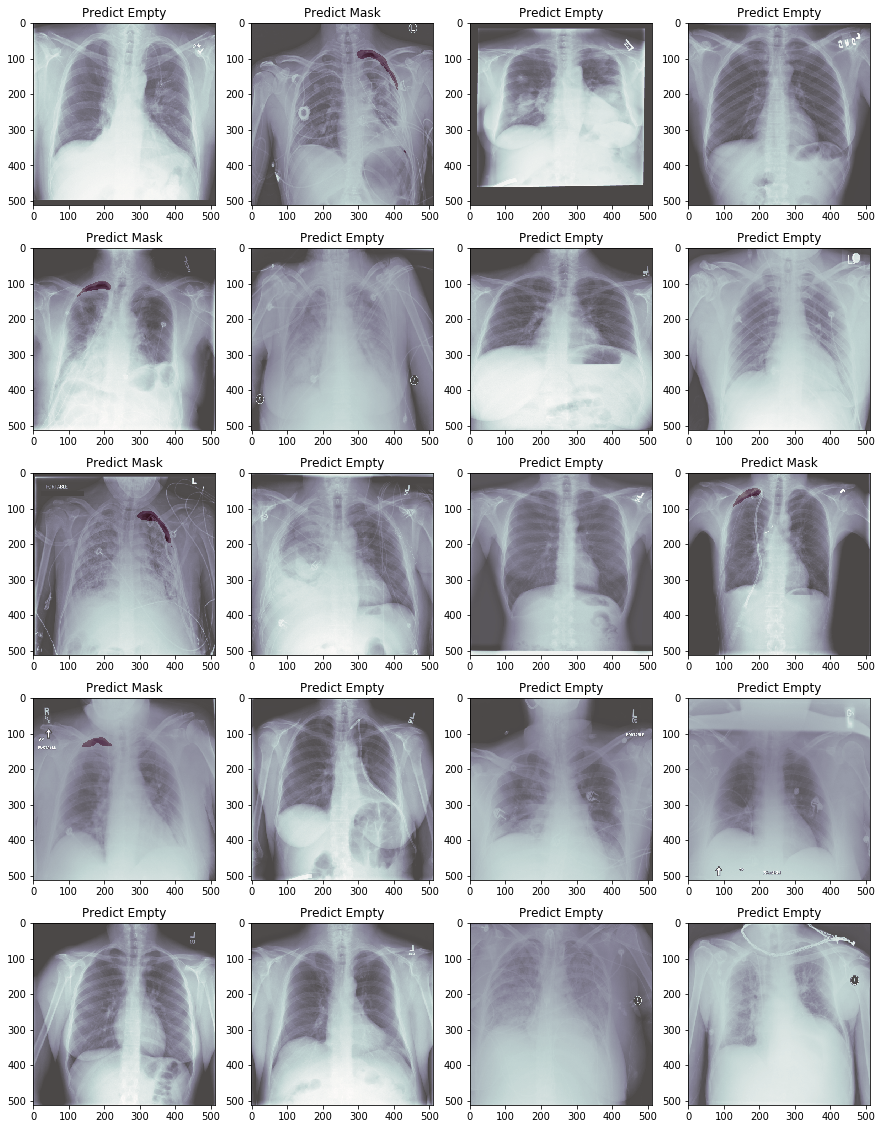

In [21]:
## visualize predicted masks
start = 0
total = 19

fig=plt.figure(figsize=(15, 20))
cnt = 0
for idx, img in enumerate(test_dl):
    if idx<start:
        continue
    for j in range(BATCH_SIZE):#BATCH_SIZE=8
        cnt+=1
        pred_mask = predict_mask(preds_test[idx*BATCH_SIZE+j], EMPTY_THRESHOLD, MASK_THRESHOLD)
        #if pred_mask.float().mean()==0:
        #    continue
        ax = fig.add_subplot(5, 4, cnt)
        plt.imshow(img[j][0].numpy(), plt.cm.bone)
        plt.imshow(pred_mask, alpha=0.3, cmap="Reds")
        if pred_mask.sum()>0:
            plt.title('Predict Mask')
        else:
            plt.title('Predict Empty')
        if cnt>total:
            break
    if cnt>total:
            break

## build submission

In [22]:
import PIL
from mask_functions import mask2rle

In [23]:
%%time
#### Step 1: Generate rle encodings (images are first converted to the original size)
rles = []
for p in tqdm_notebook(preds_test):#p is logit from model
    pred_mask = predict_mask(p, EMPTY_THRESHOLD, MASK_THRESHOLD)
    if pred_mask.sum()>0:#predicted non-empty mask
        im = PIL.Image.fromarray((pred_mask.T*255).astype(np.uint8)).resize((1024,1024))
        im = np.asarray(im)
        rles.append(mask2rle(im, 1024, 1024))
    else: rles.append('-1')
    
sub_df = pd.DataFrame({'ImageId': test_fnames, 'EncodedPixels': rles})
print(len(sub_df.index))
sub_df.head()

1377
CPU times: user 11min 23s, sys: 38 s, total: 12min 1s
Wall time: 1min 38s


In [24]:
sub_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6160.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.582.1517875163...,610470 14 1010 14 1006 24 1000 24 998 30 994 3...
2,1.2.276.0.7230010.3.1.4.8323329.6985.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.5865.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6187.151787519...,248088 4 1020 4 3062 4 1020 4 1016 10 1014 10 ...


In [25]:
# check the correctness of transformation
pred_mask = predict_mask(preds_test[22], EMPTY_THRESHOLD, MASK_THRESHOLD)
im = PIL.Image.fromarray((pred_mask.T*255).astype(np.uint8)).resize((1024,1024))
im = np.asarray(im)
im.max()

255

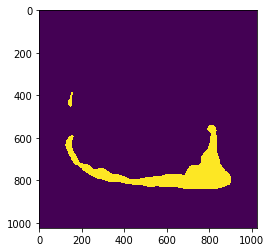

In [26]:
plt.imshow(im)

In [27]:
sub_df.to_csv('submission/0726_deeplabv3plus_512_seed3456_tta_v1.csv.gz', index=False, compression='gzip')

In [28]:
(sub_df.EncodedPixels!='-1').mean()

0.13435003631082063

In [52]:
rd_mask = np.zeros((1024, 1024))
d = 50
rd_mask[400:400+d, 400:400+d] = 1.0

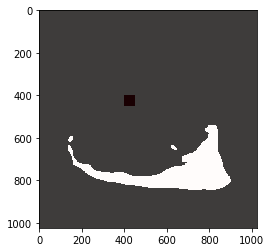

In [53]:
plt.imshow(im, cmap=plt.cm.bone)
plt.imshow(rd_mask, alpha=0.25, cmap='Reds')